In [80]:
############## Dataset Prep ##############

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

pitch_data = pd.read_csv('2019_pitches.csv')
np.random.seed(54321)

train = pitch_data.sample(n = 10000, replace = False)
pitch_data = pitch_data.drop(train.index)
test = pitch_data.sample(n = 2000, replace = False)
pitch_data['on_1b'] = pd.to_numeric(pitch_data.on_1b)

train = train[-train['code'].isin(['X','D','E'])]
train['Result'] = train['code'].map({'S':1, 'C':1, 'F':1, 'T':1,'L':1, 'W':1, 'M':1, 'Q':1, 'R':1, 'B':0, '*B':0, 'I':0, 'P':0, 'H':0})
train = train[['start_speed', 'break_angle','break_length','code','pitch_type','b_count','s_count','outs', 'Result', 'px', 'pz']]
train = train.dropna()

def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)

def confusion_matrix_data(data, actual_values, model, cutoff=.5):
    pred_values = model.predict(data)
    # Specify the bins
    bins = np.array([0,cutoff,1])
    # Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0] + cm[1,1])
    fpr = (cm[0,1])/(cm[0,0] + cm[0,1])
    precision = (cm[1,1])/(cm[1,1] + cm[0,1])
    tpr = (cm[1,1])/(cm[1,0] + cm[1,1]) # Recall
    
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.show()
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))

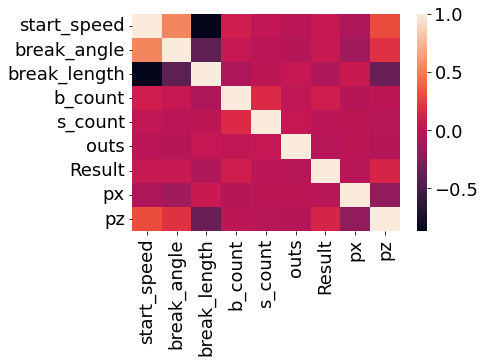

        feature          VIF
0         const  1296.068044
1   start_speed     4.759926
2   break_angle     1.437588
3  break_length     4.251973
4       b_count     1.033885
5       s_count     1.029418
6          outs     1.005690
7            px     1.045790
8            pz     1.186814


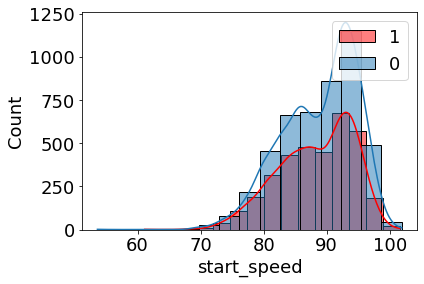

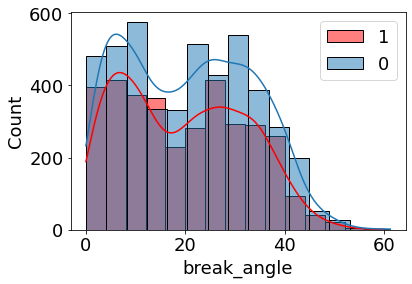

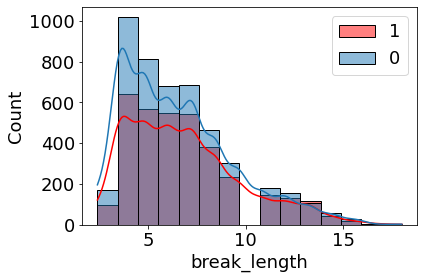

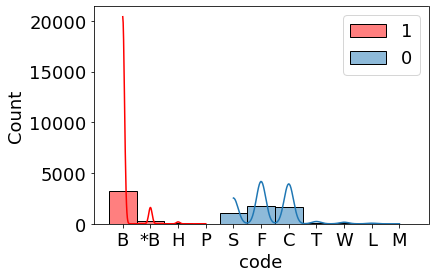

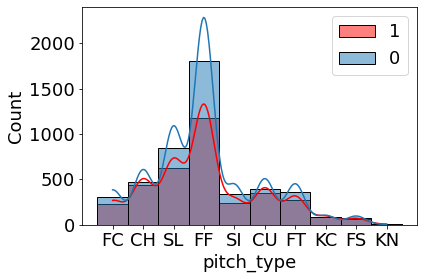

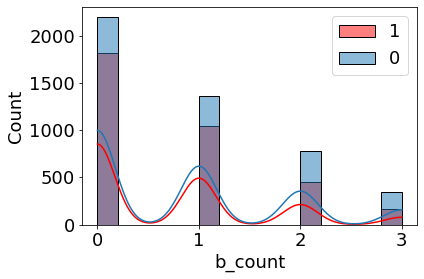

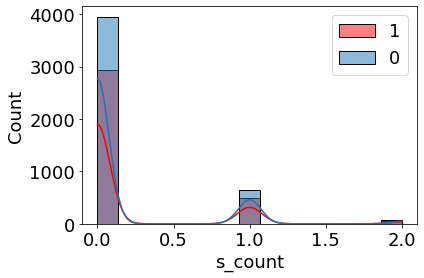

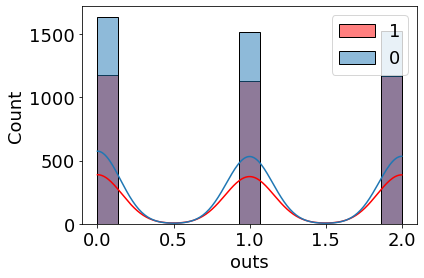

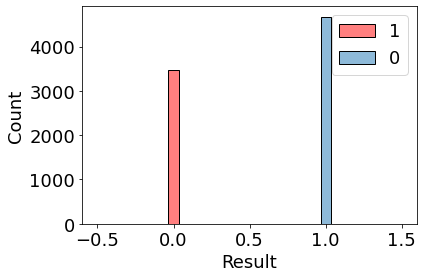

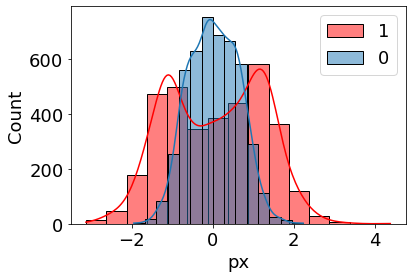

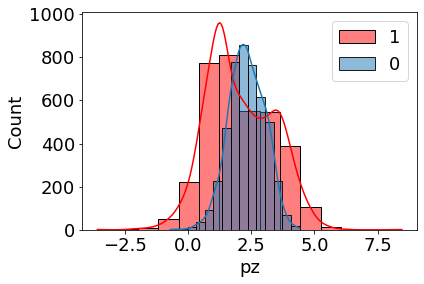

In [81]:
############## Initial Analysis ##############
# Correlations - heatmap or matrix
sns.heatmap(train.corr())
plt.show()

# Highest corrs between start speed and break angle / break length. Be on lookout for those


# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = train[['start_speed', 'break_angle','break_length','b_count','s_count','outs','px','pz']]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

# All VIFs are tolerable values.


# Density plots - x is var, y is count. 2 histograms (with lines?) for 1/0
plotdf = train.copy()
plotdf.drop(['Result','code'], axis = 1)
for i in plotdf.columns:
    a_0 = train[train['Result'] == 0][i]
    a_1 = train[train['Result'] == 1][i]
    sns.histplot(a_0, kde = True, color = 'r',bins = 15, label = '1')
    sns.histplot(a_1, kde = True, bins = 15, label = '0')
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.legend(loc='upper right')
    plt.show()
    
# Would like to drop break angle and break length, since they have highest corrs with another predictor (startspeed) and have similar histograms. Will run later lasso or stepwise regression with these vars, but hope to remove.

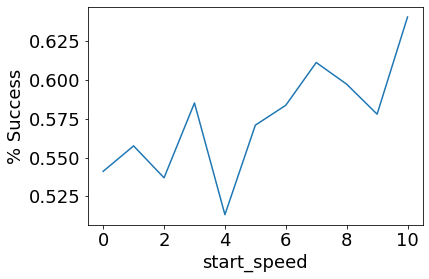

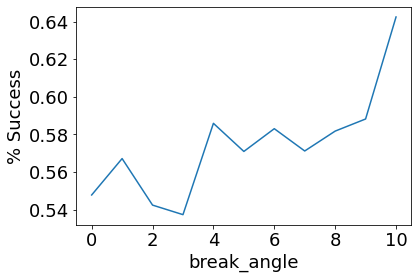

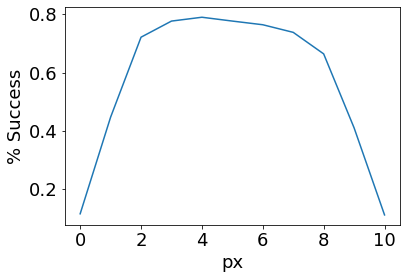

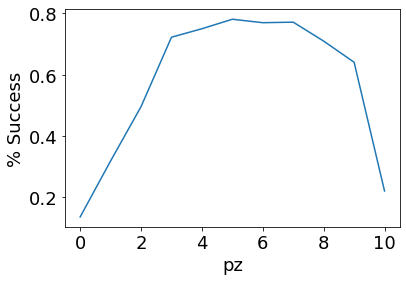

In [82]:
############## Variable Transformation ##############

Z = train[['start_speed', 'break_angle','px','pz']]
for i in Z.columns:
    binned_age = pd.qcut(train[i],11,retbins=True)
    train['age_binned'] = binned_age[0]
    #Finding percentage of people having diabetes in each Age bin
    age_data = train.groupby('age_binned')['Result'].agg([('% Success','mean'),('nobs','count')]).reset_index(drop=False)
    age_data
    #Visualizing percentage of people having diabetes with increasing Age (or Age bins)
    sns.lineplot(x = age_data.index, y= age_data['% Success'])
    plt.xlabel(i)
    plt.show()
    
# px and pz do not increase monotonically - could benefit from quadratic transformation

Optimization terminated successfully.
         Current function value: 0.397280
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 Result   No. Observations:                 8147
Model:                          Logit   Df Residuals:                     8141
Method:                           MLE   Df Model:                            5
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.4177
Time:                        16:25:19   Log-Likelihood:                -3236.6
converged:                       True   LL-Null:                       -5558.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.8725      0.193    -25.282      0.000      -5.250      -4.495
px             0.1163      0.

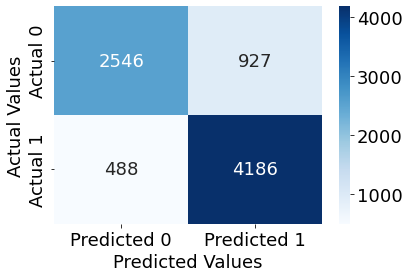

Classification accuracy = 82.6%
Precision = 81.9%
TPR or Recall = 89.6%
FNR = 10.4%
FPR = 26.7%
0.9156238091242659


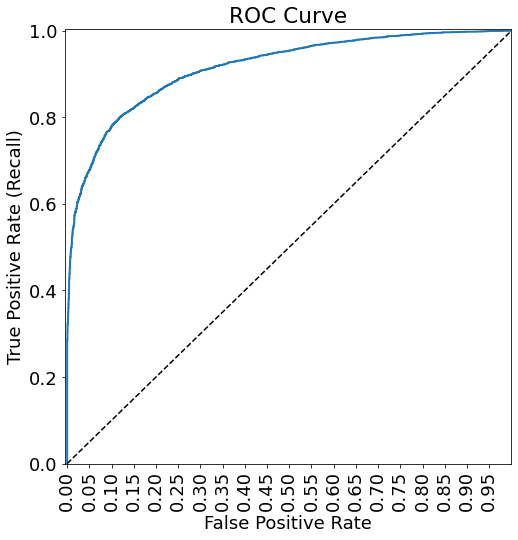

In [83]:
############## Manual Model Making ##############
logit_model = sm.logit(formula = 'Result~px+pz+b_count+I(px**2)+I(pz**2)', data = train).fit()
print(logit_model.summary())
confusion_matrix_data(train, train.Result, logit_model, cutoff = 0.5)

from sklearn.metrics import roc_curve, auc
y=train.Result
ypred = logit_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

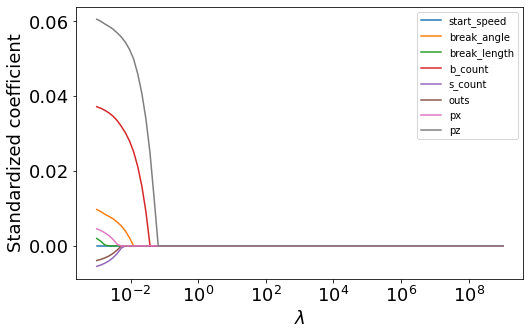

In [84]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = train[['start_speed', 'break_angle','break_length','b_count','s_count','outs','px','pz']]

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)


#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.figure(figsize=(8,5))
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(X.columns, fontsize=10)



In [85]:
logit_model.prsquared


0.4176846928292812